# Dependencies and Required Packages

In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
import seaborn as sns

[nltk_data] Downloading package punkt to /home/shinobi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/shinobi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/shinobi/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/shinobi/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
from pdfminer.high_level import extract_text
import nltk
import re
import subprocess
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shinobi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import json

# Generating Text Data From PDF File

In [4]:
filepath="./resume1.pdf"


In [5]:
def extract_text_from_pdf(pdf_path):
    text = extract_text(pdf_path)
    return text

txt = extract_text_from_pdf(filepath)


In [6]:
print(txt)

Rajat Agarwaal
Data Scientist
Skilled Data Scientist with 2.5 years of experience executing data driven solutions to increase eﬃciency,
accuracy and utility of internal data processing. Experienced at creating regression models, classiﬁcation
models  using  predictive  modelling,  Computer  Vision  and  analyzing  data  mining  algorithms  to  deliver
insights and implement action oriented solutions to complex business problems.

rajatagarwaal30@gmail.com

Ghaziabad (NCR Region), India

linkedin.com/in/rajat-agarwaal

WORK EXPERIENCE

Machine Learning Engineer
AgEYE Technologies
01/2021 - Present, 

Achievements/Tasks

09958168687

30 March, 1994

SKILLS

Python

C

Machine Learning

Deep Learning

Bangalore, India

Computer Vision

Natural Language Processing

SQL

Pig

Hive

Basics of HDFS

Undertaking data collection, preprocessing and analysis

Building models to address business problems

Statistical Analysis

Gitlab

Tableau

Propose solutions and strategies to business challenge

# Generating Name using NER

In [7]:
def extract_names(txt):
    person_names = []

    for sent in nltk.sent_tokenize(txt):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if hasattr(chunk, 'label') and chunk.label() == 'PERSON':
                person_names.append(
                    ' '.join(chunk_leave[0] for chunk_leave in chunk.leaves())
                )

    return person_names
names = extract_names(txt)
names

['Rajat',
 'Agarwaal Data Scientist Skilled Data Scientist',
 'Machine Learning Engineer',
 'Machine Learning Deep Learning Bangalore',
 'Gitlab Tableau',
 'Machine Learning',
 'Python',
 'Engineer Ericsson Global India Pvt',
 'Uttar Pradesh Built',
 'Applied ML',
 'Machine Learning',
 'Maharashtra PROJECTS Instance',
 'Instance Segmentation',
 'Basil',
 'Lettuce',
 'Hemp Image',
 'Custom CNN Architecture',
 'Stem Girth',
 'Plant Height',
 'Fresh Weight',
 'Dry Weight',
 'Basil',
 'Lettuce Classes',
 'Customer Churn Analysis',
 'Salary Advance Product',
 'Objective',
 'Random',
 'Marketing Campaign',
 'Silhouette Score',
 'Greater Noida',
 'Uttar Pradesh',
 'Python',
 'Sql',
 'Hacker Rank']

In [8]:
name_candidate = names[0] + ' ' + names[1].split(' ')[0]

# Extracting Phone Number

In [9]:
PHONE_REG_GH = re.compile(r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]')

PHONE_REG_USA = re.compile(r'/^\(?(\d{3})\)?[-]?(\d{3})[-]?(\d{4})$/') 

In [10]:
def extract_phone_number(resume_text):
    phone = re.findall(PHONE_REG_GH, resume_text)

    if phone:
        number = ''.join(phone[0])

        if resume_text.find(number) >= 0 and len(number) < 16:
            return number
    return None
 
phone_number_ind = extract_phone_number(txt)
print(phone_number_ind)

9958168687


In [11]:
def extract_phone_number(resume_text):
    phone = re.findall(PHONE_REG_USA, resume_text)

    if phone:
        if resume_text.find(phone) >= 0:
            return phone
    return None
 
phone_number_usa = extract_phone_number(txt)
print(phone_number_usa)

None


In [12]:
phone_contact=[]
if phone_number_ind != None:
  phone_contact.append(phone_number_ind)
if phone_number_usa != None:
  phone_contact.append(phone_number_usa)

phone_contact

['9958168687']

# Extracting EMAIL ID

In [13]:
EMAIL_REG = re.compile(r'[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+')

In [14]:
def extract_emails(resume_text):
    return re.findall(EMAIL_REG, resume_text)


In [15]:
emails = extract_emails(txt)

if emails:
    print(emails)
    

['rajatagarwaal30@gmail.com']


#### General Info Dictionary

In [16]:
general_dict={ 'Name' : name_candidate.upper(),
              'Email' : emails ,
              'Contact' : phone_contact
    
}

general_dict

{'Name': 'RAJAT AGARWAAL',
 'Email': ['rajatagarwaal30@gmail.com'],
 'Contact': ['9958168687']}

# Extracting Skills from the Text

In [17]:
import pandas as pd
file_skills_domain = pd.read_excel('./ResumeSkill.xlsx')

In [18]:
file_skills_domain.columns = file_skills_domain.columns.str.strip().str.upper()

In [19]:
file_skills_domain.columns

Index(['FRONT_END', 'BACK_END', 'MACHINE_LEARNING', 'DEVOPS',
       'BUSINESS_INTELLIGENCE', 'EDUCATION'],
      dtype='object')

In [20]:
list_domains=[]
for col in file_skills_domain.columns:
  
  file_skills_domain[col] = file_skills_domain[col].str.strip().str.upper()

  if col != 'EDUCATION' :
    list_domains.append('%s' % col)
    globals()['%s' % col]= [x for x in file_skills_domain[col].to_list() if type(x) != float]

In [21]:
list_domains

['FRONT_END',
 'BACK_END',
 'MACHINE_LEARNING',
 'DEVOPS',
 'BUSINESS_INTELLIGENCE']

In [22]:
list_skills = []
for i in list_domains:
  list_skills=list_skills + eval(i)
print(list_skills)

['HTML/CSS', 'HTML', 'CSS', 'JAVASCRIPT', 'JAVASCRIPT', 'JQUERY', 'BOOTSTRAP', 'VERSION CONTROL/GIT', 'SASS', 'LESS', 'STYLUS', 'ANGULARJS', 'ES6', 'ANGULAR', 'REACT', 'VUE.JS', 'METEOR', 'NODE.JS', 'BACKBONE.JS', 'AURELIA', 'CHROME DEVTOOLS', 'AGILE/SCRUM', 'UI/UX', 'TYPESCRIPT', 'REACTJS', 'GITHUB', 'ES7', 'PHOTOSHOP', 'ADOBE ILLUSTRATOR', 'WORDPRESS', 'JQUERY', 'JAVA', 'PYTHON', 'RUBY', '.NET', 'C++', 'PERL', 'PHP', 'POSTGRES SQL', 'MYSQL', 'MONGODB', 'ORACLE', 'REDIS', 'SQL SERVER', 'DOCKER', 'KUBERNETES', 'NGINX', 'NODE.JS', 'APACHE', 'NGINX', 'IIS SERVERS', 'MICROSOFT IIS', 'REST API', 'SOAP API', 'EXPRESS.JS', 'PHOENIX (ELIXIR)', 'DJANGO', 'RUBY ON RAILS', 'LARAVEL', 'FLASK', 'ASP.NET CORE', 'SPRING MVC', 'CODEIGNITER', 'CAKEPHP', 'SYMFONY', 'PLAY FRAMEWORK', 'C#', 'GITHUB', 'MICROSERVICES', 'NPM', 'YARN', 'GRAPHQL', 'MOBX', 'REDUX', 'ORM', 'DYNAMODB', 'CICD', 'GITLAB', 'DOT NET', 'R', 'JAVA', 'PYTHON', 'C++', 'TORCH', 'THEANO', 'TENSORFLOW', 'SWIFT AI', 'SCIKIT-LEARN', 'PYBRAIN

### Skills Extraction Loop

In [23]:
from collections import defaultdict
skills_dict = {}
domain_list = []


def extract_skills(input_text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    word_tokens = nltk.tokenize.word_tokenize(input_text)

    # remove the stop words
    filtered_tokens = [w for w in word_tokens if w not in stop_words]

    # remove the punctuation
    filtered_tokens = [w for w in word_tokens if w.isalpha()]

    # generate bigrams and trigrams (such as artificial intelligence)
    bigrams_trigrams = list(map(' '.join, nltk.everygrams(filtered_tokens, 1, 3)))

    # we create a set to keep the results in.
    found_skills = set()

    # we search for each token in our skills database
    for token in filtered_tokens:
        if token.upper() in list_skills:
            found_skills.add(token)
    
    # we search for each bigram and trigram in our skills database
    for ngram in bigrams_trigrams:
        if ngram.upper() in list_skills:
            found_skills.add(ngram)
            

    for skill in found_skills :
      if skill.upper() not in skills_dict.keys():
          skill = skill.upper()
          cnt = 0
          for i in bigrams_trigrams:
              i = i.upper()
              if skill in i:
                  cnt += 1
                  for j in list_domains:
                    if skill in eval(j):
                      domain_list.append(j)

          print(skill.upper(), ' is repeated ' , cnt, ' times.')
          skills_dict[skill.upper()]= cnt
#     print(list(bigrams_trigrams))
            

In [24]:
extract_skills(txt)

# print(skills) 

COMPUTER VISION  is repeated  9  times.
SQL  is repeated  18  times.
PYTHON  is repeated  24  times.
RANDOM FORESTS  is repeated  3  times.
CNN  is repeated  6  times.
TABLEAU  is repeated  6  times.
GITLAB  is repeated  6  times.


[Text(0.5, 0, 'Skills'),
 Text(0, 0.5, '% Proficiency'),
 Text(0.5, 1.0, 'SKILLS PROFICIENCY OF CANDIDATE ')]

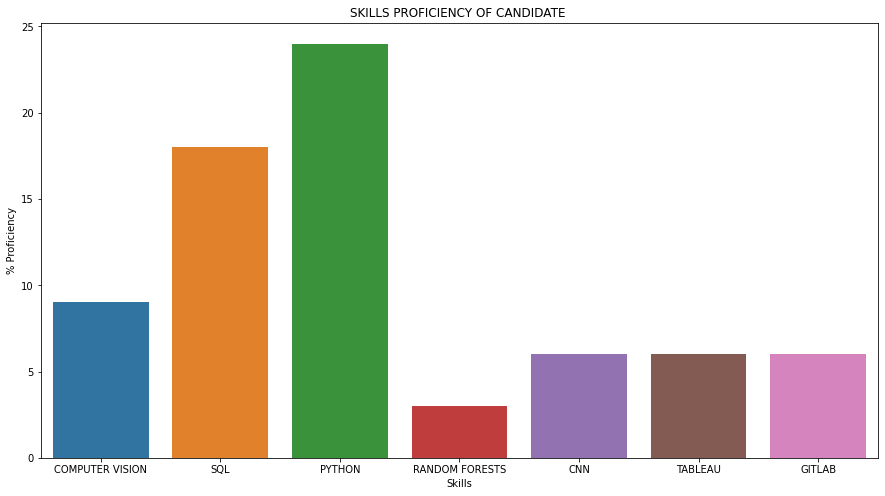

In [25]:
from matplotlib import pyplot as plt
plt.figure(figsize = (15,8))

skills_dict
my_df = pd.DataFrame(skills_dict.items())
ax = sns.barplot(x = 0, y = 1, data = my_df)
ax.set(xlabel = 'Skills', ylabel = '% Proficiency', title = 'SKILLS PROFICIENCY OF CANDIDATE ')


[Text(0.5, 0, 'Domain'),
 Text(0, 0.5, '% Score'),
 Text(0.5, 1.0, 'FIELD SPECIALITY OF CANDIDATE')]

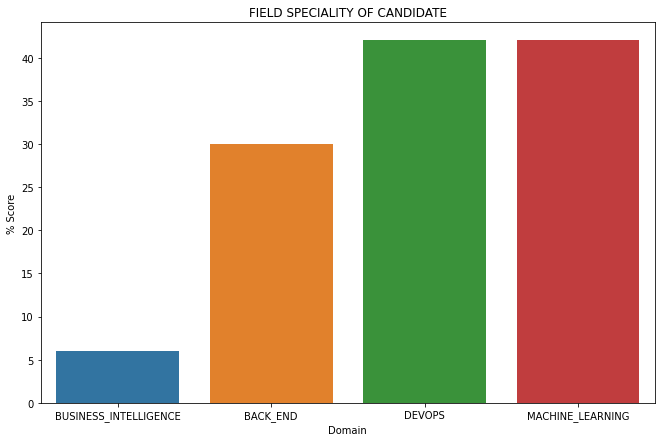

In [26]:
domain_list

from collections import Counter
plt.figure(figsize=(11,7))


new_vals = Counter(domain_list).most_common()
new_vals = new_vals[::-1] #this sorts the list in ascending order

domain_dict = {}
for a, b in new_vals:
    domain_dict[a] = b
 

my_df = pd.DataFrame(domain_dict.items())
ax = sns.barplot(x = 0, y = 1, data = my_df)
ax.set(xlabel = 'Domain', ylabel = '% Score', title = 'FIELD SPECIALITY OF CANDIDATE')


In [27]:
general_dict["skills"] = skills_dict
general_dict["domain"] = [new_vals[-1][0],new_vals[-2][0]]

### Final Information

In [28]:
general_dict

{'Name': 'RAJAT AGARWAAL',
 'Email': ['rajatagarwaal30@gmail.com'],
 'Contact': ['9958168687'],
 'skills': {'COMPUTER VISION': 9,
  'SQL': 18,
  'PYTHON': 24,
  'RANDOM FORESTS': 3,
  'CNN': 6,
  'TABLEAU': 6,
  'GITLAB': 6},
 'domain': ['MACHINE_LEARNING', 'DEVOPS']}

In [29]:
from pandas import json_normalize 
skill_df = json_normalize(general_dict['skills'])
num = skill_df.sum(axis = 1)[0]

list_details = []
for skill_x in skill_df.columns:
    list_details.append({'doc':filepath ,'Name' : name_candidate.upper(),
              'email' : emails[0] ,
              'contact' : phone_contact[0],
              'domain':[new_vals[-1][0][5:],new_vals[-2][0][5:]],
              'skills':skill_x ,
              'normalised_count':round((skill_df[skill_x][0]*100)/num,2),
              'total_skills':list(skill_df.columns)
              })
# pd.DataFrame(list_details)

### Checking Similarity to Job Description

In [30]:
import docx2txt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

job_description = docx2txt.process("./job_desc.docx")
resume = docx2txt.process("./resume1.docx")

text = [resume, job_description]

# Calculate similarity score 
cv = CountVectorizer()
count_matrix = cv.fit_transform(text)
print("\Similarity Score: ")
print(cosine_similarity(count_matrix))

# Count match percentage
match_percentage = cosine_similarity(count_matrix)[0][1] * 100
match_percentage = round(match_percentage, 2)
print()
print("The match percentage of the resume is ", match_percentage,"%")


\Similarity Score: 
[[1.         0.72070421]
 [0.72070421 1.        ]]

The match percentage of the resume is  72.07 %
